**Imports**

In [121]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


**Daten laden**<br>
Rohdaten werden aus einem Verzeichnis geladen und einem Dictionary data hinzugefügt.<br>
Sollten Keine csv-Daten vorhanden sein bleibt das Dictionary data leer.

In [122]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


Die Funktion load_csv_data wird mit dem Parameter des Verzeichnises in dem sich die csv-Daten befinden aufgerufen und der Variable data zugewiesen.<br>
Danach wird versucht die jeweiligen Zeilen Gyroscope und Linear_Acceleration aus den jeweiligen Sprungdaten und Kniebeugendaten zu lesen.<br>
Sollte einer der Schlüssel nicht gefunden werden wird ein KeyError geworfen.

In [123]:
data = load_csv_data('csv_data')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


Es werden statische Informationen der jeweiligen Daten ausgegeben.

Die Funktion trim_dataframes_to_shortest kürzt alle übergebenen Dataframes auf die Länge des kürzesten Dataframes.<br>
Es wird die minimale Länge aller Dataframes bestimmt und anschließend werden alle Dataframes auf die minimale Länge gekürzt.

In [124]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

Hier wird die Funktion trim_dataframes_to_shortest mit den geladenen Daten aufgerufen.

In [125]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

Hier werden statische Informationen zu den nun gekürzten Daten ausgegeben.

In [126]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.022010,0.704642,0.177169,0.349645
std,2.889770,0.986032,12.297720,2.986639
min,0.024174,-3.810173,-15.460706,-7.029371
25%,2.522923,0.174252,-9.752974,-1.630308
50%,5.022130,0.753718,-4.991462,0.126350
75%,7.520972,1.301103,10.097296,1.730946
max,10.019233,3.623628,31.554523,10.272612


In [127]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,-0.005314,0.001743,0.009130
std,2.889771,0.458255,0.218534,0.251720
min,0.014226,-1.205879,-0.704140,-0.725978
25%,2.512944,-0.306264,-0.132625,-0.159790
50%,5.012181,-0.035154,0.003196,-0.007457
75%,7.511023,0.249805,0.128897,0.160322
max,10.009284,1.778992,0.759001,0.805873


**Funktion zum Plotten**<br>
Die Funktion compare_acc_gyr erhält Daten aus den Accelerometer- und Gyroscope-DataFrames und plottet diese.<br>
Als erstes wird ein neuer subplot erstellt.<br>
Danach wird für jede Achse ein Scatter-Plot angelegt.<br>
Abschließend wird das Layout des Plots aktualisiert und ausgegeben.

In [128]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=2000)
    fig.show()

Es wird die Funktion compare_acc_gyr mit den Sprung- bzw Kniebeugen-Daten aufgerufen.

In [129]:
compare_acc_gyr(jump_acc,jump_gyr)

In [130]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [131]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.022010,0.704642,0.177169,0.349645
std,2.889770,0.986032,12.297720,2.986639
min,0.024174,-3.810173,-15.460706,-7.029371
25%,2.522923,0.174252,-9.752974,-1.630308
50%,5.022130,0.753718,-4.991462,0.126350
75%,7.520972,1.301103,10.097296,1.730946
max,10.019233,3.623628,31.554523,10.272612


In [132]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,-0.005314,0.001743,0.009130
std,2.889771,0.458255,0.218534,0.251720
min,0.014226,-1.205879,-0.704140,-0.725978
25%,2.512944,-0.306264,-0.132625,-0.159790
50%,5.012181,-0.035154,0.003196,-0.007457
75%,7.511023,0.249805,0.128897,0.160322
max,10.009284,1.778992,0.759001,0.805873


Die Funktion combine_relevant_columns erhält zwei Dataframes und erstellt ein neues Dataframe das nur bestimmte relevante Daten enthält.<br>
Es werden die Spalten für die Lineare Beschleunigung auf der z und y Achse sowie die x Achse und die Zeit des Gyroscopes gelesen.<br>
Am Ende wird ein neues Dataframe ausgegeben mit den gelesenen Spalten.<br>

In [133]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })

Hier wird die Funktion combine_relevant_columns aufgerufen und anschließend werden statische Informationen sowie die ersten Zeilen des Dataframes ausgegeben.

In [134]:
combined_df = combine_relevant_columns(jump_acc, jump_gyr)
combined_df.describe()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,0.349645,0.177169,-0.005314
std,2.889771,2.986639,12.297720,0.458255
min,0.014226,-7.029371,-15.460706,-1.205879
25%,2.512944,-1.630308,-9.752974,-0.306264
50%,5.012181,0.126350,-4.991462,-0.035154
75%,7.511023,1.730946,10.097296,0.249805
max,10.009284,10.272612,31.554523,1.778992


In [135]:
combined_df.describe()


,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,0.349645,0.177169,-0.005314
std,2.889771,2.986639,12.297720,0.458255
min,0.014226,-7.029371,-15.460706,-1.205879
25%,2.512944,-1.630308,-9.752974,-0.306264
50%,5.012181,0.126350,-4.991462,-0.035154
75%,7.511023,1.730946,10.097296,0.249805
max,10.009284,10.272612,31.554523,1.778992


In [136]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [137]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

**Fast Fourier Transformation**<br>
Die Funktion plot_frequencies nutzt die Fast Fourier Transformation um die Frequenzen von Daten aus dem Dataframe zu analysieren und darzustellen.<br>
Es wird ein neuer Plot erstellt.<br>
Die Spalte Time (s) wird aus dem Dataframe entfernt da sie für die Frequenzanalyse nicht benötigt wird.<br>
Danach wird die Anzahl der verbleibenden Spalten im gefilterten Dataframe ermittelt.<br>
Als nächstes wird eine Schleife durchlaufen um die Frequenzanalyse für jede Spalte im Dataframe durchzuführen.<br>
Die Amplituden werden normalisiert in dem sie durch den Maximalen Amplitudenwert geteilt werden.<br>
Es werden nur die positiven Frequenzen betrachtet und die entsprechenden Werte werden extrahiert.<br>
Als letztes werden die einzelnen Subplots erstellt wobei für jede Spalte im Dataframe ein eigener Subplot erstellt wird.<br>
Es wird in jedem Subplot die Frequenz gegen die normalisierte Amplitude aufgetragen.<br>
Abschließend wird mit tight_layout gewährleistet das die Subplots ordentlich angeordnet sind um Überlappungen zu vermeiden und die Plots werden ausgegeben.<br>

In [138]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])
    num_columns = len(filtered_df.columns)

    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        # Normalisierung der Amplituden
        max_amplitude = np.max(amplitudes)
        normalized_amplitudes = amplitudes / max_amplitude

        # Filtern für positive Frequenzen
        positive_indices = np.where(frequencies > 0)
        positive_frequencies = frequencies[positive_indices]
        positive_normalized_amplitudes = normalized_amplitudes[positive_indices]

        # Erstellen der Subplots
        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_normalized_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

Aufruf der Funktion plot_frequencies mit den Kniebeugen-Daten

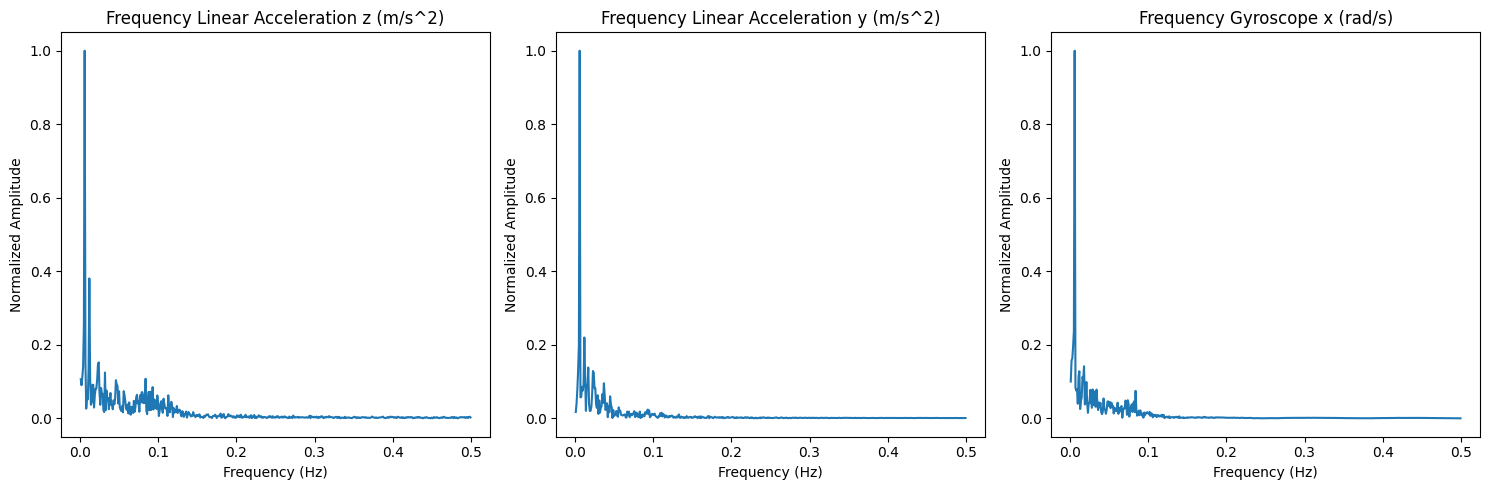

In [139]:
plot_frequencies(squat_df)

Aufruf der Funktion plot_frequencies mit den Springen-Daten

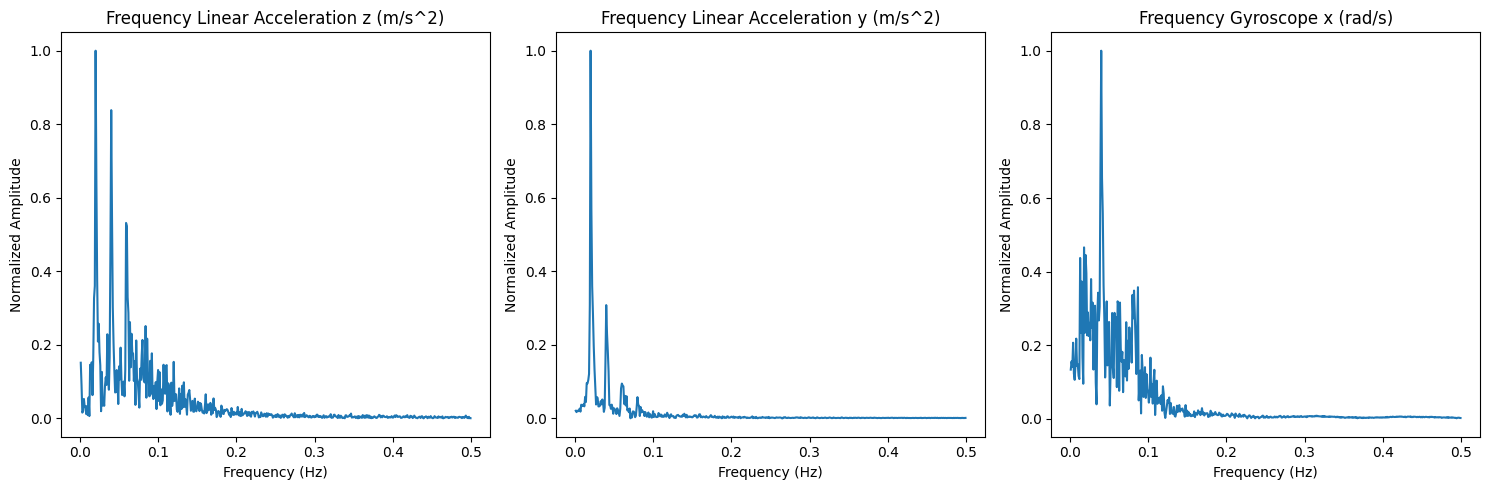

In [140]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

Die Funktion filter_frequency führt einen Butterworth-Tiefpassfilter auf das mitgegebene Dataframe durch.<br>
Es wird eine Kopie des übergebenen Dataframes erstellt um die gefilterten Daten zu speichern.<br>
Die Filterordnung wird auf 5 festgelegt und der low_cutoff Frequenz wird auf 5Hz festgelegt.<br>
Als nächstes wird der Butterworth Tiefpassfilter erstellt mit b und a als Koeffizienten.<br>
Es wird über alle Spalten außer Time (s) mit einer Schleife iteriert und der Filter wird auf die jeweiligen Spalten angewendet und in das neue Kopierte Dataframe gespeichert.<br>
Abschließend wird das Dataframe mit den neuen gefilterten Daten zurückgegeben.

In [141]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 5
    high_cutoff = 0.3
    low_cutoff = 10

    # Butterworth Tiefpass erstellen
    b, a = butter(filter_order, [high_cutoff,low_cutoff], btype='band', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

Hier wird die Funktion filter_frequency mit den Kniebeuge-Daten aufgerufen.

In [142]:
filtered_df_sq = filter_frequency(squat_df)

Hier wird die Funktion filter:frequency mit den Springen-Daten aufgerufen.

In [143]:
filtered_df_j = filter_frequency(jump_df)

**Funktion zum Plotten der gefilterten Daten**<br>
Die Funktion plot_df nimmt ein Dataframe und gibt am Ende ein Plot aus.<br>
Es werden zwei Subplots erstellt um jeweils die Lineare Beschleunigung auf der x und y -Achse des Dataframes zu visiualisieren.<br>
Es wird ein weiterer Subplot erstellt um die Daten des Gyroscopes auf der x-Achse zu visiualisieren.

In [144]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=2000)
    fig.show()

Die Funktion plot_normal_df gibt Plots für Normalisierte-Daten aus einem Dataframe aus.<br>
Es werden zwei Subplots erstellt um jeweils die Lineare Beschleunigung auf der y und z -Achse des Dataframes zu visiualisieren.<br>
Es wird ein weiterer Subplot für die normalisierten-Gyroscopedaten an der x-Achse erstellt.<br>
Die erstellten Plots werden am Ende ausgegeben.

**Frequenz gefiltert**<br>
Beobachtungen für Springen sowie Kniebeugen Plots:<br>
Die Plots der beiden Beschleunigungen auf der y sowie z -Achse sind sich extrem ähnlich.<br>
Die Ausschläge des Gyroscopes passen zu den Ausschlägen der Beschleunigung.

In [145]:
plot_df(filtered_df_j)

In [146]:
plot_df(filtered_df_sq)

In [147]:
def normalize_df(df, columns_to_scale):
    # Kopie des DataFrames erstellen
    normalized_df = df.copy()

    # Initialisieren des MinMaxScaler
    scaler = MinMaxScaler()

    # Fit des Scalers auf die Daten
    scaler.fit(normalized_df[columns_to_scale])

    # Transformieren der Daten
    normalized_columns = scaler.transform(normalized_df[columns_to_scale])
    
    # Ersetzen der Originaldaten durch die normalisierten Daten
    normalized_df[columns_to_scale] = normalized_columns

    return normalized_df

In [148]:
columns_to_normalize = ['Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Gyroscope x (rad/s)']

# Anwenden der Normalisierungsfunktion
normalized_df_sq = normalize_df(filtered_df_sq, columns_to_normalize)
normalized_df_j = normalize_df(filtered_df_j, columns_to_normalize)

Min-Max-Skalierung

In [149]:
plot_df(normalized_df_sq)

In [150]:
plot_df(normalized_df_j)

In [151]:
sq_peaks, _ = find_peaks(normalized_df_sq['Linear Acceleration y (m/s^2)'],prominence=0.5, height=0.5)
peak_distances = np.diff(sq_peaks)
sq_mean_distance = np.mean(peak_distances)

j_peaks, _ = find_peaks(normalized_df_j['Linear Acceleration y (m/s^2)'],prominence=0.5,height=0.5)
peak_distances = np.diff(j_peaks)
j_mean_distance = np.mean(peak_distances)


print(f"Anzahl der Peaks Kniebeuge: {len(sq_peaks)}")
print(f"Anzahl der Peaks Sprung: {len(j_peaks)}")

Anzahl der Peaks Kniebeuge: 5
Anzahl der Peaks Sprung: 20


**Peaks extrahieren**<br>
Für eine gute Identifizierung von Zyklen in unseren Daten, ist das Herauslesen von Peaks hilfreich:<br>
Weil sie im späteren Prozess dazu Beitragen ein optimaleres Windowing zu erreichen, wo möglichst ganze <br>
Perioden abgedeckt werden, und so mehr Datennutzbarkeit hergestellt werden kann<br>
Weil der Bewegungszyklus an erster stelle durch die Geschwindigkeitskomponente auf<br>
 der y-Achse bestimmt wird, werden peaks aus <br>
der Spalte 'Linear Acceleration y (m/s^2)' extrahiert <br>

In [152]:
normalized_df_sq['Label'] = 'squat'
normalized_df_j['Label'] = 'jump'

**Label_df**<br>
Zum späteren Klassifizieren im Entscheidungsbaum wurden beiden Dataframes labels zugewiesen.

In [153]:
def create_windows_and_labels(df, peaks, window_size):
    windows = []
    label_list = []

    for peak in peaks:
        half_window = window_size // 2

        start_index = int(max(peak - half_window, 0))
        end_index = int(min(peak + half_window, df.shape[0]))

        window = df.iloc[start_index:end_index]
        windows.append(window)

        label = df.iloc[int(peak)]['Label']
        label_list.append(label)

    label_df = pd.DataFrame(label_list, columns=['Label'])

    return windows, label_df


**Erstellen dynamischer Windows**<br>
Hier werden die Windows basierend auf einer Fenstergröße links und rechts um den peak mit halber Fenstergröße festgelegt.<br>
Die Fenstergröße basiert immer auf den maximal

In [154]:
def create_windows(df, peaks, window_size):
    windows = []

    for peak in peaks:
        half_window = window_size // 2

        start_index = int(max(peak - half_window, 0))
        end_index = int(min(peak + half_window, df.shape[0]))

        window = df.iloc[start_index:end_index]
        windows.append(window)

    return windows

In [155]:
sq_windows, sq_label_df = create_windows_and_labels(normalized_df_sq,sq_peaks, sq_mean_distance)

In [156]:
j_windows,j_label_df = create_windows_and_labels(normalized_df_j,j_peaks, j_mean_distance)

**Windowing**<br>
Die Windowgröße wird auf mean_distance gesetzt<br>

In [157]:
def plot_windows_with_data(df, windows, peaks):
    # Farben für die Fenster in Accel Y definieren
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

    # Erstellen des Plots mit Plotly
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accel Y', 'Gyro X', 'Accel Z'))

    # Hinzufügen der Accelerometer Y-Daten und Peaks
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y', line=dict(color='grey')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Time (s)'].iloc[peaks], y=df['Linear Acceleration y (m/s^2)'].iloc[peaks], mode='markers', marker=dict(color='red', size=6), name='Peaks Y'), row=1, col=1)

    # Hervorheben der Fenster in Accel Y mit verschiedenen Farben
    for i, window in enumerate(windows):
        window_color = colors[i % len(colors)]
        fig.add_trace(go.Scatter(x=window['Time (s)'], y=window['Linear Acceleration y (m/s^2)'], mode='lines', line=dict(color=window_color, width=2)), row=1, col=1)

    # Hinzufügen der Gyroscope X-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], name='Gyro X', line=dict(color='blue')), row=2, col=1)

    # Hinzufügen der Linear Acceleration Z-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z', line=dict(color='green')), row=3, col=1)

    # Update layout and labels
    fig.update_layout(title='Accelerometer Daten mit Peaks und farblichen Fenstern in Accel Y', xaxis_title='Zeit (s)', height=900, width=2000)
    fig.show()


**Visualisierung des Windowings**<br>
Hierfür wurde eine Funktion geschrieben, welche den y-Beschleunigungsgraphen farblich in Fenster einteilt<br>
 und dazu noch Peaks visualisiert

In [158]:
plot_windows_with_data(normalized_df_sq, sq_windows, sq_peaks)

In [159]:
print(normalized_df_sq.describe())

          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.011073                       0.404175   
std       2.888941                       0.167918   
min       0.014470                       0.000000   
25%       2.512914                       0.282504   
50%       5.010961                       0.370924   
75%       7.509221                       0.523144   
max      10.007646                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.406364             0.528325  
std                         0.226820             0.248697  
min                         0.000000             0.000000  
25%                         0.215919             0.316686  
50%                         0.407969             0.550216  
75%                         0.563855             0.754288  
max                         1.000000      

In [160]:
plot_windows_with_data(normalized_df_j, j_windows, j_peaks)

In [161]:
print(normalized_df_j.describe())

          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.414833   
std       2.889771                       0.189527   
min       0.014226                       0.000000   
25%       2.512944                       0.280652   
50%       5.012181                       0.399371   
75%       7.511023                       0.515795   
max      10.009284                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.328086             0.419707  
std                         0.229963             0.162052  
min                         0.000000             0.000000  
25%                         0.144277             0.310583  
50%                         0.239153             0.412794  
75%                         0.499386             0.504632  
max                         1.000000      

In [162]:
def balance_windows_and_labels(smaller_windows, larger_windows, smaller_labels, larger_labels):
    factor = len(larger_windows) // len(smaller_windows)
    remainder = len(larger_windows) % len(smaller_windows)

    # Die kleinere Liste mehrfach wiederholen
    smaller_windows_balanced = smaller_windows * factor
    smaller_labels_balanced = pd.concat([smaller_labels] * factor)

    # Die ersten 'remainder' Elemente der kleineren Liste anhängen
    smaller_windows_balanced += smaller_windows[:remainder]
    smaller_labels_balanced = pd.concat([smaller_labels_balanced, smaller_labels.iloc[:remainder]])

    return smaller_windows_balanced, smaller_labels_balanced


**Ausbalancieren der Fenster**<br>
Durch die Verschiedenheit der Fenstergrößen zwischen Kniebeuge und Sprung, ist es für das Training mit dem Entscheidungsbaum erforderlich, die Windows und somit auch die Labels Dataframes auf eine Größe zu bringen.<br>

In [163]:
def balance_windows(smaller_windows, larger_windows):
    factor = len(larger_windows) // len(smaller_windows)
    remainder = len(larger_windows) % len(smaller_windows)

    # Die kleinere Liste mehrfach wiederholen
    smaller_windows_balanced = smaller_windows * factor
    # Die ersten 'remainder' Elemente der kleineren Liste anhängen
    smaller_windows_balanced += smaller_windows[:remainder]

    return smaller_windows_balanced


In [164]:
if len(sq_windows) < len(j_windows):
    # Balance Squat Windows to match Jump Windows
    sq_windows, sq_label_df = balance_windows_and_labels(sq_windows, j_windows, sq_label_df, j_label_df)
else:
    # Balance Jump Windows to match Squat Windows
    j_windows, j_label_df = balance_windows_and_labels(j_windows, sq_windows, j_label_df, sq_label_df)

# Kombinieren der Fenster und Labels
label_df = pd.concat([sq_label_df, j_label_df], ignore_index=True)
windows = sq_windows + j_windows

# Überprüfen der Längen
print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")
print(f"Anzahl der Labels für jump: {len(j_label_df)}")
print(f"Anzahl der Labels für squat: {len(sq_label_df)}")

Anzahl der Fenster für jump: 20
Anzahl der Fenster für squat: 20
Anzahl der Labels für jump: 20
Anzahl der Labels für squat: 20


In [165]:
def create_feature_df(windows):
    # Leere Liste erstellen, um Features zu speichern
    feature_list = []

    # Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
    for window in windows:
        acc_y = window['Linear Acceleration y (m/s^2)']
        acc_z = window['Linear Acceleration z (m/s^2)']
        gyro_x = window['Gyroscope x (rad/s)']
        window_length = len(window)

        mean_acc_z = acc_z.mean()
        mean_acc_y = acc_y.mean()
        mean_gyro_x = gyro_x.mean()
        quantile_75_acc_y = acc_y.quantile(0.75)
        quartile_25_acc_y = acc_y.quantile(0.25)
        peak_acc_y = acc_y.max()
        
        if not acc_z.empty:
            acc_z_fft = np.fft.fft(acc_z)
            fft_magnitudes_z = np.abs(acc_z_fft)
            fft_magnitudes_z_sum = fft_magnitudes_z.sum()
        else:
            # Standardwert festlegen oder alternative Logik implementieren
            fft_magnitudes_z_sum = 0 

        

        # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
        features = {
            'window_length': window_length,
            'peak_acc_y': peak_acc_y,
            'fft_magnitudes_z_sum': fft_magnitudes_z_sum ,
            'mean_acc_y': mean_acc_y,
            'mean_acc_z': mean_acc_z,
            'mean_gyro_x': mean_gyro_x,
            'quantile_75_acc_y': quantile_75_acc_y,
            'quantile_25_acc_y': quartile_25_acc_y,
        }
        feature_list.append(features)

    return pd.DataFrame(feature_list)


Genauigkeit des Entscheidungsbaum-Classifiers: 1.0


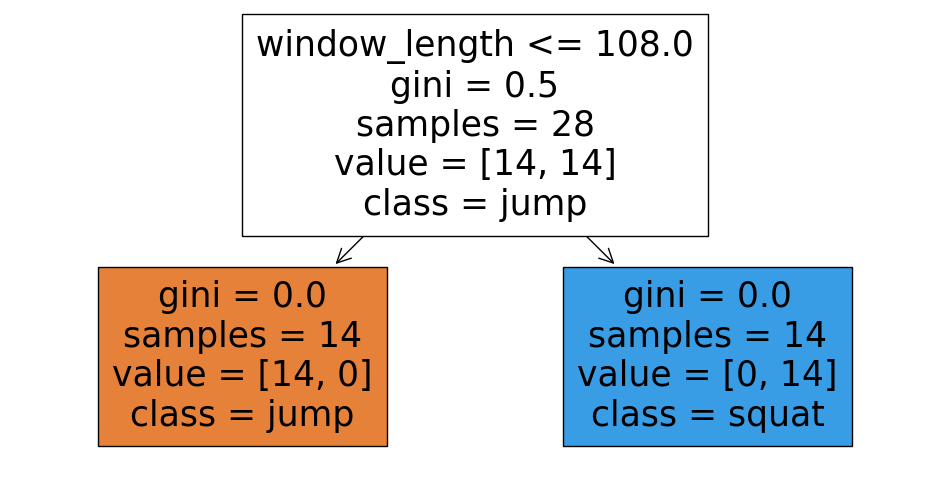

|--- window_length <= 108.00
|   |--- class: jump
|--- window_length >  108.00
|   |--- class: squat



In [166]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Angenommen, feature_df und label_df sind bereits definiert
feature_df = create_feature_df(windows)
X = feature_df
y = label_df

# Daten aufteilen mit stratifizierter Aufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Erstelle und trainiere den Entscheidungsbaum-Classifier
clf = DecisionTreeClassifier( random_state=42)
clf.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred = clf.predict(X_test)

# Berechne die Genauigkeit des Classifiers
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Entscheidungsbaum-Classifiers: {accuracy}")

# Visualisiere den Entscheidungsbaum
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns.tolist(), class_names=clf.classes_.tolist())
plt.show()

# Visualisiere den Entscheidungsbaum in Textform
tree_text = export_text(clf, feature_names=X.columns.tolist())
print(tree_text)


Clustering

In [167]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



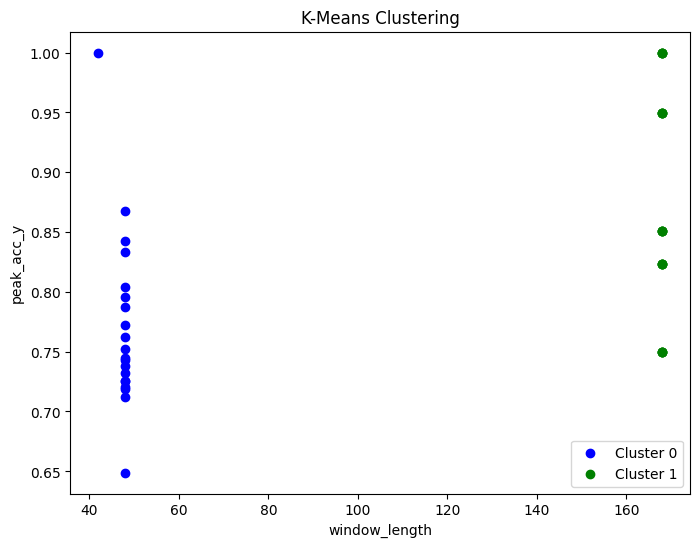

In [168]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['window_length'], cluster_data['peak_acc_y'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('window_length')
plt.ylabel('peak_acc_y')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()

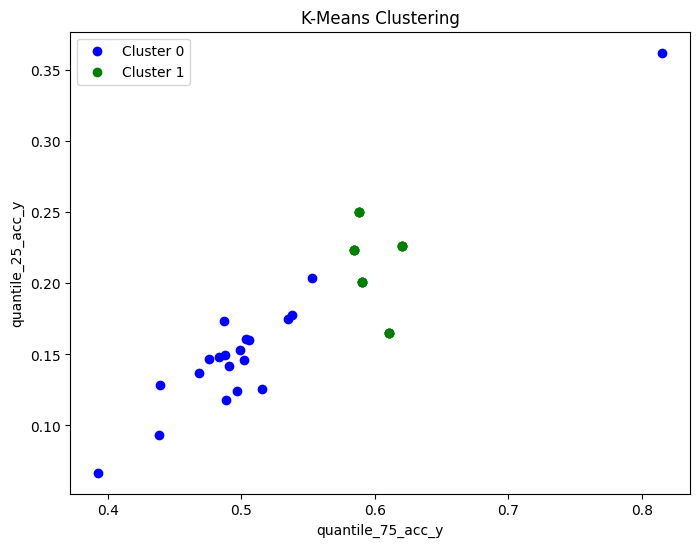

In [169]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['quantile_75_acc_y'], cluster_data['quantile_25_acc_y'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('quantile_75_acc_y')
plt.ylabel('quantile_25_acc_y')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()

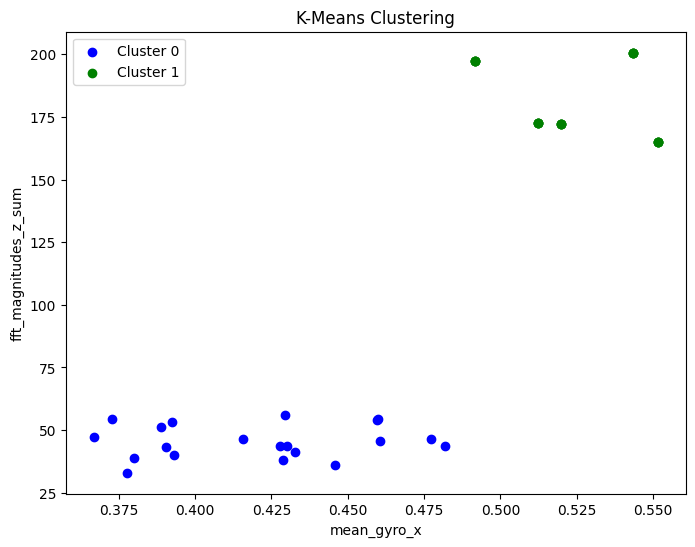

In [170]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['mean_gyro_x'], cluster_data['fft_magnitudes_z_sum'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('mean_gyro_x')
plt.ylabel('fft_magnitudes_z_sum')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()

Testdaten einlesen

In [171]:
data = load_csv_data('csv_test')
print(data.keys())

try:
    gyr = data['Gyroscope']
    acc = data['Linear Acceleration']
except KeyError as e:
    print(f"Key not found: {e}")

dict_keys(['Gyroscope', 'Linear Acceleration'])


In [172]:
acc, gyr = trim_dataframes_to_shortest([acc, gyr])

In [173]:
compare_acc_gyr(acc,gyr)

In [174]:
compare_acc_gyr(acc,gyr)

In [175]:
combined_df = combine_relevant_columns(acc, gyr)

In [176]:
filtered_df = filter_frequency(combined_df)

In [177]:
columns_to_normalize = ['Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Gyroscope x (rad/s)']
normalized_df = normalize_df(filtered_df, columns_to_normalize)

In [178]:
peaks, _ = find_peaks(normalized_df_sq['Linear Acceleration y (m/s^2)'],prominence=0.5, height=0.5)
peak_distances = np.diff(peaks)
mean_distance = np.mean(peak_distances)


print(f"Anzahl der Peaks: {len(peaks)}")

Anzahl der Peaks: 5


In [179]:
windows = create_windows(normalized_df, peaks, mean_distance)

In [180]:
feature_df = create_feature_df(windows)

In [181]:
new_predictions = clf.predict(feature_df)

print(new_predictions)

['squat' 'squat' 'jump' 'jump' 'jump']
